Observation:

        Type: Box(4)
        Num     Observation               Min                     Max
        0       Cart Position             -4.8                    4.8
        1       Cart Velocity             -Inf                    Inf
        2       Pole Angle                -0.418 rad (-24 deg)    0.418 rad (24 deg)
        3       Pole Angular Velocity     -Inf                    Inf

 Actions:
 
        Type: Discrete(2)
        Num   Action
        0     Push cart to the left
        1     Push cart to the right

In [1]:
import gym
import numpy as np
from itertools import product

env = gym.make('CartPole-v0')

state_space = env.observation_space
n_state_feat = state_space.shape[0]

print("n_state_feat",n_state_feat)

action_space = env.action_space
n_action = action_space.n
actions = np.asarray(range(n_action))
print(actions)
print("n_actions",n_action)
# print("action space",action_space)

#parameters
epsilon = 5e-2  # probability of choosing a random action (changed from original value of 0.0)
alpha = 5e-5 # learning rate
lambda_ = 0.9  # trace decay rate
gamma = 1  # discount rate

order = 5

k = n_state_feat

d = (order+1) ** k

w = np.zeros((d,n_action))

combinations = None
combinations_generated = False



n_state_feat 4
[0 1]
n_actions 2


In [2]:
iterations = 500


In [3]:
def get_feature(env, state, order=5, k=4):
    
    global combinations, combinations_generated
    
#     Clipped State
    low = np.array([-2.4, -5.0, -0.21, -2.5])         # CartPole
    high = np.array([2.4, 5.0, 0.21, 2.5])
    
    clipped = np.clip(state, low, high)
    
    # Normalize the state
    normalized = (clipped - low) / (high - low)
    
    
    # Compute Fourier-Basis features
    if combinations_generated == False:
        combinations = np.array(list(product(range(order + 1), repeat = k)))
        combinations_generated = True
        
    features = np.cos(np.pi * np.matmul(combinations, np.expand_dims(normalized, axis=1)))
    
    return np.asarray(features)
        

def get_pi(pi,q,n_action, epsilon = 0.05):
    
    a_star = np.argwhere(q[:] == np.amax(q[:])).flatten()
    
    num_a = len(a_star)
    
    y  = (epsilon/n_action)
    x = ((1-epsilon)/num_a)+ y

    for a in range(n_action):

        if(a in a_star):
            pi[a] = x
        else:
            pi[a] = y
    return pi

def update_q(q , w , env , state , actions ,  order = 5 , k = 4):
    
    x = np.squeeze(get_feature(env,state, order = order, k = k))

    for a in actions:
        q[a] = w[:,a].dot(x)

    return (q,x)

In [4]:
def sarsa_lambda(env, w , n_state_feat , actions, n_action, n_dims , alpha , lambda_ , epsilon , gamma, iterations,order,k):
    events = 10
    hist_len = np.zeros((events,iterations))
    for event in range(events):
        print("Event is ",event)
        #Loop over episodes

        ##################Start########################

        q = np.zeros(n_action) #need to be changed as n_state should be a vector

        pi = np.zeros(n_action)
        
        w = np.zeros((n_dims,n_action))

        for iteration in range(iterations): #Looping for each episode

            s = env.reset()

            done = False

            q , x = update_q(q, w, env, s, actions,  order, k) # updating q

            pi = get_pi(pi,q,n_action, epsilon)

            a = np.random.choice(actions , p = pi)

            z = np.zeros(n_dims) # eligibility vector

            Q_old = 0 # scalar

            episode_length = 0

            while not done:
                episode_length +=1

                # Perform the action
                s_dash, R, done, _ = env.step(a) #observing R and S'

                # Next Action
                q_dash , x_dash = update_q(q, w, env, s_dash, actions,  order, k) # updating q

                pi = get_pi(pi,q_dash,n_action, epsilon)

                a_dash = np.random.choice(actions,p = pi)

                Q = w[:,a].dot(x)

                Q_dash = w[:,a_dash].dot(x_dash)

                delta = R + gamma * Q_dash - Q           

                z = gamma * lambda_* z + (1 - alpha*gamma*lambda_*(z.dot(x))) * x 

                w[:,a] = w[:,a] + alpha * ( delta + Q - Q_old ) * z - alpha * ( Q - Q_old ) * x

                Q_old = Q_dash

                x = x_dash
                a = a_dash

            #print("length is ",episode_length)
            hist_len[event,iteration] = episode_length
        print("Episode_lengths",hist_len[event,:])
    return hist_len

In [5]:
episode_lengths_history = sarsa_lambda(env, w , n_state_feat , actions, n_action, d , alpha , lambda_ , epsilon , gamma, iterations,order,k)

Event is  0
Episode_lengths [ 30. 200. 200. 200.   9. 149.  90. 137. 200. 200. 200. 200. 200. 200.
 200. 200. 200. 200. 200. 200. 200. 200. 200. 200. 200. 200. 200. 200.
 200. 200. 200. 200. 200. 200. 200. 200. 200. 200. 200. 200. 200. 200.
 200. 200. 200. 200. 200. 200. 200. 200. 200. 200. 200. 200. 200. 200.
 200. 200. 200. 200. 200. 200. 200. 200. 200. 200. 200. 200. 200. 200.
 200. 200. 200. 200. 200. 200. 200. 200. 200. 200. 200. 200. 200. 200.
 200. 200. 200. 200. 200. 200. 200. 200. 200. 200. 200. 200. 200. 200.
 200. 200. 200. 200. 200. 200. 200. 200. 200. 200. 200. 200. 200. 200.
 200. 200. 200. 200. 200. 200. 200. 200. 200. 200. 200. 200. 200. 200.
 200. 200. 200. 200. 200. 200. 200. 200. 200. 200. 200. 200. 200. 200.
 200. 200. 200. 200. 200. 200. 200. 200. 200. 200. 200. 200. 200. 200.
 200. 200. 200. 200. 200. 200. 200. 200. 200. 200. 200. 200. 200. 200.
 200. 200. 200. 200. 200. 200. 200. 200. 200. 200. 200. 200. 200. 200.
 200. 200. 200. 200. 200. 200. 200. 200. 200. 200

Episode_lengths [ 22.  15.  10.   8.   9.   9.  10.  10.  11.   8.   9.  10.  10.  11.
  10.   9.   9.  11.  10.   9.   9.  10.   8.  10.  12.   9.   9.  10.
   9.   9.  10.   9.  10.   9.   9.   9.  10.  10.  10.   9.  10.  13.
  10.  10.  10.  10.   9.   9.  10.   9.  10.   8.  10.   9.  10.   8.
   9.  12.  10.  10.  10.   9.   9.  10.  10.   9.  10.  10.  10.  10.
  10.   8.   9.  11.  10.   9.  11.   9.   9.  10.  10.  11.  10.  10.
   9.   8.  10.  10.   9.   8.  10.  11.   9.  10.  11.  10.  10.  10.
   9.  10.  12.   8.   9.  10.   9.  10.  10.   9.   8.  10.  10.  10.
   9.  11.  11.   9.   9.  11.  10.  14.  10.  11.   8.   8.  11.  10.
  10.   9.  10.  10.   9.   8.   8.   9.   9.  12.  10.   9.   8.  10.
  10.  10.   9.  10.  10.   8.  10.   9.  10.  10.   9.  10.  10.  10.
  12.  10.  11.  10.  10.   9.   8.  11.   8.   9.  10.   8.   9.  11.
  10.   9.   9.   8.   9.   8.  12.   9.   9.  10.  10.  10.  10.  10.
  10.  10.  10.   8.   9.  10.  10.  10.  10.   9.   9.  10. 

Episode_lengths [ 29. 200. 200. 200.  11. 200. 200. 200. 200. 200. 200. 200. 200. 200.
 200. 200. 200. 200. 200. 200. 200. 200. 200. 200. 200. 200. 200. 200.
 200. 200. 200. 200. 200. 200. 200. 200. 200. 200. 200. 200. 200. 200.
 200. 200. 200. 200. 200. 200. 200. 200. 200. 200. 200. 200. 200. 200.
 200. 200. 200. 200. 200. 200. 200. 200. 200. 200. 200. 200. 200. 200.
 200. 200. 200. 200. 200. 200. 200. 200. 200. 200. 200. 200. 200. 200.
 200. 200. 200. 200. 200. 200. 200. 200. 200. 200. 200. 200. 200. 200.
 200. 200. 200. 200. 200. 200. 200. 200. 200. 200. 200. 200. 200. 200.
 200. 200. 200. 200. 200. 200. 200. 200. 200. 200. 200. 200. 200. 200.
 200. 200. 200. 200. 200. 200. 200. 200. 200. 200. 200. 200. 200. 200.
 200. 200. 200. 200. 200. 200. 200. 200. 200. 200. 200. 200. 200. 200.
 200. 200. 200. 200. 200. 200. 200. 200. 200. 200. 200. 200. 200. 200.
 200. 200. 200. 200. 200. 200. 200. 200. 200. 200. 200. 200. 200. 200.
 200. 200. 200. 200. 200. 200. 200. 200. 200. 200. 200. 200. 

In [6]:
episode_lengths_avg = np.mean(episode_lengths_history, axis=0)
episode_lengths_std = np.std(episode_lengths_history, axis=0)

In [7]:
print(episode_lengths_avg)

[ 62.4 105.5  97.8  67.1  48.   99.6  93.9  99.  106.1 123.8 122.2 123.9
 123.9 114.8 123.7 123.7 124.  123.9 123.7 122.  121.7 105.5 123.8 124.1
 112.  112.6 123.8 121.6 122.4 121.2 124.  112.3 113.2 123.8 123.6 122.8
 123.8 123.8 124.  112.9 124.1 124.3 122.4 123.7 123.4 114.  123.7 123.9
 113.3 122.3 123.1 123.  123.5 123.7 113.1 123.7 123.5 123.9 123.9 123.9
 123.8 124.  123.8 121.6 123.6 123.8 122.4 115.7 123.9 123.8 123.5 123.4
 123.8 123.8 124.  123.6 123.1 123.8 123.8 123.7 115.2 124.  123.5 122.9
 123.7 123.1 123.3 121.7 124.3 123.7 123.3 112.6 122.8 123.5 122.9 122.8
 124.  114.2 113.8 123.7 122.8 112.7 125.1 125.9 121.5 124.8 134.8 132.5
 141.1 141.1 142.2 137.8 122.1 113.4 124.  140.8 132.3 132.  132.5 141.7
 134.5 141.8 131.4 141.  132.2 131.7 133.1 139.  140.7 141.4 126.5 140.5
 140.7 141.1 131.8 132.4 141.2 140.8 141.1 140.9 140.9 132.1 140.8 132.6
 141.1 140.7 132.2 139.9 141.4 140.4 142.7 141.6 140.5 132.1 141.  141.5
 132.3 132.1 140.9 141.9 140.9 132.2 141.6 139.8 14

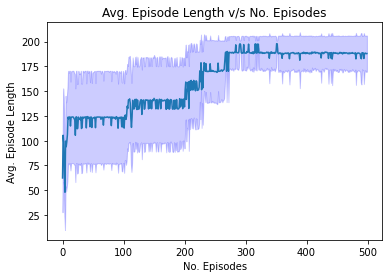

In [9]:
import matplotlib.pyplot as plt
plt.plot(np.arange(iterations), episode_lengths_avg)
plt.fill_between(np.arange(iterations), episode_lengths_avg - episode_lengths_std / 2, \
                 episode_lengths_avg + episode_lengths_std / 2, color='blue', alpha=0.2)
plt.title('Avg. Episode Length v/s No. Episodes')
plt.xlabel('No. Episodes')
plt.ylabel('Avg. Episode Length')
plt.savefig("/home/sahil/Desktop/CS 687/Project/sarsa_lambda_cartpole.png")
plt.show()